In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('./test_score.ipynb'))))

import numpy as np
import pandas as pd

from ylearn.estimator_model._generalized_forest.tree._grf_tree import GrfTree
from ylearn.estimator_model._generalized_forest._grf import GRForest
from ylearn.exp_dataset.exp_data import sq_data
from ylearn.utils._common import to_df
from ylearn.estimator_model._naive_forest.utils import grad, grad_coef, inverse_grad

from numpy.linalg import lstsq, inv

from copy import deepcopy


n = 2000
d = 10     
n_x = 1
y, x, v = sq_data(n, d, n_x)

true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_x - 1))])
w = deepcopy(v)
v_test = v[:min(100, n)].copy()
v_test[:, 0] = np.linspace(np.percentile(v[:, 0], 1), np.percentile(v[:, 0], 99), min(100, n))
data = to_df(treatment=x, outcome=y, v=v)
test_data = to_df(v=v_test)

outcome = 'outcome'
treatment = 'treatment'
adjustment = data.columns[2:]
from sklearn.preprocessing import OneHotEncoder
oh = OneHotEncoder()
# x = oh.fit_transform(x).toarray().astype(np.float32)



gtre = GrfTree(max_depth=100000, max_leaf_nodes=np.int(100000))
gtre._fit_with_array(x, y, w, v, i=1)
gtre.tree_.predict(v[:50].astype(np.float32)).squeeze()

building the 2 tree


array([ 0.11593581,  0.12825947, -0.30536784,  1.1952514 ,  2.87365318,
       -0.01498388,  1.35105983,  2.19031003, -0.12149348,  1.48035956,
       -0.30536784,  1.2836452 ,  1.86068012, -0.49240833,  1.12166108,
        0.95465896,  1.86068012,  1.57214923,  1.8749126 , -0.44288891,
       -0.32020137, -0.38585696,  0.67278507, -0.68834723,  2.93284407,
       -0.48651932,  3.12882491,  3.28512382,  0.66574452,  1.42928579,
        1.14738291,  2.48772049,  1.1169508 ,  1.46792761, -0.55730316,
        1.96256574,  3.92225231,  0.31827251,  0.52096221,  0.05755382,
        2.24739999,  0.40953207, -0.12709334,  0.37853453,  1.59054867,
        0.31217888,  0.35407687,  0.92624628,  0.16343452,  1.25773908])

In [2]:
gtre.tree_.n_node_samples

array([2000, 1863,  137, ...,    1,    1,    1], dtype=int64)

In [3]:
from ylearn.estimator_model._naive_forest import _GrfTree, NaiveGrf
gt = _GrfTree()
gt._fit_with_array(x=x, y=y.squeeze(), w=w, v=v, i=1)

building 2-th tree


In [4]:
gt._predict_with_array(w[:50], v=v[:50])

array([ 3.13885206e-01, -3.06026049e-01,  1.71559724e+00, -2.71350038e-01,
        4.02624824e-04,  1.49921012e-01,  2.14000336e-01, -7.11162160e-01,
        2.80058766e+00,  1.48035956e+00,  2.81545914e-01, -1.17725023e-01,
        1.28364520e+00, -3.84078177e-01, -3.84078177e-01,  1.38628565e-01,
       -7.66250441e-01, -3.84078177e-01,  1.87491260e+00,  1.87491260e+00,
        1.15900478e+00, -3.20201366e-01,  2.20334568e+00, -7.05173263e-01,
        1.46992891e+00,  3.54841921e+00,  1.45465015e+00, -1.53209495e-01,
       -8.78429145e-02, -2.24286892e-01, -4.40836781e-01,  2.62236404e+00,
        1.46047854e+00, -1.09418837e-01,  3.90361259e-01,  6.62914192e-01,
       -2.75186666e-01,  3.18272514e-01,  5.82868938e-02, -4.33897478e-01,
        3.26893827e+00,  1.31313758e+00,  1.49921012e-01, -5.37285693e-01,
        1.59054867e+00,  3.12178882e-01,  1.45465015e+00,  1.15900478e+00,
       -3.84078177e-01, -2.80234744e-01])

In [8]:
grf = GRForest(n_jobs=1, n_estimators=250, max_depth=100, max_leaf_nodes=100, verbose=0,)
grf.fit(
    data=data, outcome=outcome, treatment=treatment, adjustment=adjustment, covariate=adjustment
)

building the 1 tree
building the 2 tree
building the 3 tree
building the 4 tree
building the 5 tree
building the 6 tree
building the 7 tree
building the 8 tree
building the 9 tree
building the 10 tree
building the 11 tree
building the 12 tree
building the 13 tree
building the 14 tree
building the 15 tree
building the 16 tree
building the 17 tree
building the 18 tree
building the 19 tree
building the 20 tree
building the 21 tree
building the 22 tree
building the 23 tree
building the 24 tree
building the 25 tree
building the 26 tree
building the 27 tree
building the 28 tree
building the 29 tree
building the 30 tree
building the 31 tree
building the 32 tree
building the 33 tree
building the 34 tree
building the 35 tree
building the 36 tree
building the 37 tree
building the 38 tree
building the 39 tree
building the 40 tree
building the 41 tree
building the 42 tree
building the 43 tree
building the 44 tree
building the 45 tree
building the 46 tree
building the 47 tree
building the 48 tree
b

In [9]:
effect = grf._prepare4est(test_data)

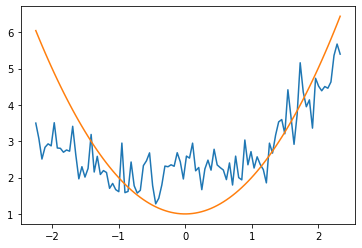

In [10]:
import matplotlib.pyplot as plt

true_te = lambda X: np.hstack([X[:, [0]]**2 + 1, np.ones((X.shape[0], n_x - 1))])

for t in range(n_x):
    plt.plot(v_test[:, 0], effect[:, t])
    plt.plot(v_test[:, 0], true_te(v_test)[:, t])
plt.show()